In [1]:
DATA_PATH = "../dataset/dataset2.0/" # Path to data
EMB_PRE_PATH = "/home/bli/.cache/torch/hub/checkpoints/esm1b_t33_650M_UR50S.pt" 
EMBED_PATH =DATA_PATH+'/ESM_embed/'
EMB_LAYER = 33
CHECKPOINT_PATH = './ESM_finetuning/checkpoint_cnn1d'
import os
import pandas as pd
import pathlib
import pandas as pd
import torch
from torch import nn 
from esm import Alphabet, FastaBatchedDataset, ProteinBertModel, pretrained, MSATransformer



In [2]:
class ProteinExtractionParams:
    def __init__(
        self,
        model_location=EMB_PRE_PATH,
        fasta_file = None,
        csv_file = None,
        toks_per_batch = 1024,
        repr_layers=[33],
        include='mean',
        truncation_seq_length = 512,
        nogpu=False,
    ):
        self.model_location = model_location
        self.fasta_file = fasta_file
        self.csv_file = csv_file
        self.toks_per_batch = toks_per_batch
        self.repr_layers = repr_layers
        self.include = include
        self.truncation_seq_length = truncation_seq_length
        self.nogpu = nogpu
args = ProteinExtractionParams()

In [3]:
esm1b,alphabet = pretrained.load_model_and_alphabet(args.model_location)
from sklearn.model_selection import train_test_split
def CreateDataSet(csv_list):
    dflist = []
    for csv_file  in csv_list:
        dflist.append(pd.read_csv(csv_file))
    data_df = pd.concat(dflist)
    data_df = data_df.sample(frac=1, random_state=42).reset_index(drop=True)
    train_df,val_df = train_test_split(data_df,test_size=0.2)
    # class FastaBatchedDataset(object):
    #     def __init__(self, sequence_labels, sequence_strs):
    #         self.sequence_labels = list(sequence_labels)
    #         self.sequence_strs = list(sequence_strs)
    train_dataset = FastaBatchedDataset(train_df['label'],train_df['seq'])
    train_batches = train_dataset.get_batch_indices(args.toks_per_batch, extra_toks_per_seq=1)
    train_dataloader = torch.utils.data.DataLoader(
        train_dataset, collate_fn=alphabet.get_batch_converter(args.truncation_seq_length), batch_sampler=train_batches
    )
    
    val_dataset = FastaBatchedDataset(val_df['label'],val_df['seq'])
    val_batches = val_dataset.get_batch_indices(args.toks_per_batch, extra_toks_per_seq=1)
    val_dataloader = torch.utils.data.DataLoader(
        val_dataset, collate_fn=alphabet.get_batch_converter(args.truncation_seq_length), batch_sampler=val_batches
    )
    # print(f"Read {args.csv_file} with {len(dataset)} sequences")
    return train_dataloader,val_dataloader

In [4]:
csvlist = [DATA_PATH+'positive_train_422.csv',DATA_PATH+'negative_train_3307.csv']
train_dataloader,val_dataloader = CreateDataSet(csvlist)


In [5]:
len(train_dataloader)

1029

In [6]:
len(val_dataloader)

261

In [7]:
class ESM_CNN1d(nn.Module):
  def __init__(self,kernel_sizes = [3, 4, 5], n_classes=2,args = None,num_channels = [512, 512, 512]):
    super(ESM_CNN1d, self).__init__()
    self.esm1b,self.alphabet = pretrained.load_model_and_alphabet(args.model_location)
    self.dropout = nn.Dropout(0.5)
    self.pool = nn.AdaptiveAvgPool1d(1)
    self.relu = nn.ReLU()
    # 创建多个一维卷积层
    self.convs = nn.ModuleList()
    for c, k in zip(num_channels, kernel_sizes):
        self.convs.append(nn.Conv1d(1280, c, k))
    self.relu = nn.ReLU()
    self.decoder = nn.Linear(sum(num_channels), n_classes)
    self.softmax = nn.Softmax(dim=1)
  def forward(self, strs,toks):
    return_contacts = "contacts" in args.include
    out = self.esm1b(toks, repr_layers=args.repr_layers, return_contacts=return_contacts)
    embeddings = out["representations"][33]
    embeddings = embeddings.permute(0, 2, 1)
    encoding = torch.cat([
        torch.squeeze(self.relu(self.pool(conv(embeddings))), dim=-1)
        for conv in self.convs], dim=1)
    outputs = self.decoder(self.dropout(encoding))
    return outputs

In [8]:

# Load ESM-2 model
batch_converter = alphabet.get_batch_converter()
# Prepare data (first 2 sequences from ESMStructuralSplitDataset superfamily / 4)
data = [
    ("protein1", "MKTVRQERLKSIVRILERSKEPVSGAQLAEELSVSRQVIVQDIAYLRSLGYNIVATPRGYVLAGG"),
    ("protein2", "KALTARQQEVFDLIRDHISQTGMPPTRAEIAQRLGFRSPNAAEEHLKALARKGVIEIVSGASRGIRLLQEE"),
    ("protein2 with mask","KALTARQQEVFDLIRD<mask>ISQTGMPPTRAEIAQRLGFRSPNAAEEHLKALARKGVIEIVSGASRGIRLLQEE"),
    ("protein3",  "K A <mask> I S Q"),
]
batch_labels, batch_strs, batch_tokens = batch_converter(data)
batch_lens = (batch_tokens != alphabet.padding_idx).sum(1)
# Extract per-residue representations (on CPU)
with torch.no_grad():
    out = esm1b(batch_tokens, repr_layers=[33], return_contacts=True)
token_representations = out["representations"][33]
print(token_representations.shape)
representations = {
    layer: t.to(device="cpu") for layer, t in out["representations"].items()
}
return_contacts=True
if return_contacts:
    contacts = out["contacts"].to(device="cpu")
x = [] 
for i, tokens in enumerate(batch_tokens):
    result = {}
    truncate_len = min(args.truncation_seq_length, len(batch_strs[i]))

    result["representations"] = {
        layer: t[i, 1 : truncate_len + 1].clone()
        for layer, t in representations.items()
    }

    result["mean_representations"] = {
        layer: t[i, 1 : truncate_len + 1].mean(0).clone()
        for layer, t in representations.items()
    }
    result["bos_representations"] = {
        layer: t[i, 0].clone() for layer, t in representations.items()
    }
    result["contacts"] = contacts[i, : truncate_len, : truncate_len].clone()
    
    x.append(result['bos_representations'][33])
x = torch.vstack((*x,))


torch.Size([4, 73, 1280])


In [9]:
representations[33].shape

torch.Size([4, 73, 1280])

In [10]:
model_eval = ESM_CNN1d(args=args)
model_eval.eval()
model_eval(batch_strs,batch_tokens)

tensor([[-0.0767,  0.0034],
        [-0.0502,  0.0281],
        [-0.0509,  0.0266],
        [-0.0157,  0.0413]], grad_fn=<AddmmBackward0>)

In [11]:
import utils
def accuracy(y_hat, y):  #@save
    """计算预测正确的数量"""
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = y_hat.argmax(axis=1)
    cmp = y_hat.type(y.dtype) == y
    return float(cmp.type(y.dtype).sum())

def evaluate_accuracy(net, data_iter):  #@save
    """计算在指定数据集上模型的精度"""
    if isinstance(net, torch.nn.Module):
        net.eval()  # 将模型设置为评估模式
    metric = utils.Accumulator(2)  # 正确预测数、预测总数
    with torch.no_grad():
        for batch_idx, (labels, strs, toks) in enumerate(data_iter):
            metric.add(accuracy(net(strs,toks), labels), labels.numel())
    return metric[0] / metric[1]
def evaluate_accuracy_gpu(net, data_iter, devices):
    """使用GPU计算模型在数据集上的精度

    Defined in :numref:`sec_lenet`"""
    net.eval()  # 设置为评估模式
    # 正确预测的数量，总预测的数量
    metric = utils.Accumulator(2)
    with torch.no_grad():
        for batch_idx, (labels, strs, toks) in enumerate(data_iter):
            labels = torch.tensor(labels)
            labels = labels.to(devices[0])
            toks = toks.to(devices[0])
            metric.add(accuracy(net(strs,toks), labels), labels.numel())
    return metric[0] / metric[1]

def train_batch(net, strs,X, y, loss, trainer, devices):

    X = X.to(devices[0])
    y = y.to(devices[0])
    net.train()
    trainer.zero_grad()
                
    pred = net(strs,X)
    l = loss(pred, y)
    l.sum().backward()
    trainer.step()
    train_loss_sum = l.sum()
    train_acc_sum = accuracy(pred, y)
    return train_loss_sum, train_acc_sum

def main(net, train_dataloader, val_dataloader, loss, trainer, num_epochs, start_epoch, devices = utils.try_all_gpus()):
    #####################建立一个日志用来储存训练进度
    import logging
    #记录器
    logger = logging.getLogger()
    logger.setLevel(logging.INFO)
    #处理器
    consoleHandler = logging.StreamHandler()
    consoleHandler.setLevel(logging.DEBUG)
    #默认使用logger的级别
    fileHandler = logging.FileHandler(filename = "./ESM_finetuning/Finetuning_ESM_log/esm_cnn_acc.log")
    #格式
    formatter = logging.Formatter("%(asctime)s|%(message)s",)
    #给处理器设置格式
    consoleHandler.setFormatter(formatter)
    fileHandler.setFormatter(formatter)
    #记录器设置处理器
    logger.addHandler(consoleHandler)
    logger.addHandler(fileHandler)

    #########################################
    """用多GPU进行模型训练"""
    timer, num_batches = utils.Timer(), len(train_dataloader)
    animator = utils.Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0, 1],
                            legend=['train loss', 'train acc', 'test acc'])
    net = nn.DataParallel(net, device_ids=devices).to(devices[0])
    best_acc = 0
    for epoch in range(start_epoch, num_epochs):
        # 4个维度：储存训练损失，训练准确度，实例数，特点数
        metric = utils.Accumulator(4)
        print(f'epoch {epoch + 1} is processing')
        
        
        
        for batch_idx, (labels, strs, toks) in enumerate(train_dataloader):
            
            timer.start()
            labels = torch.tensor(labels)
            if torch.cuda.is_available() and not args.nogpu:
                toks = toks.to(device="cuda", non_blocking=True)
            l, acc = train_batch(
                net,strs, toks, labels, loss, trainer, devices)
            metric.add(l, acc, labels.shape[0], labels.numel())
            timer.stop()
            if (batch_idx + 1) % (num_batches // 5) == 0 or batch_idx == num_batches - 1:
                animator.add(epoch + (batch_idx + 1) / num_batches,
                             (metric[0] / metric[2], metric[1] / metric[3],
                              None))


        test_acc = evaluate_accuracy_gpu(net, val_dataloader,devices)
        animator.add(epoch + 1, (None, None, test_acc))
        logger.info(f'epoch {epoch + 1}/{num_epochs}:'\
            f' loss {metric[0] / metric[2]:.3f}, train acc {metric[1] / metric[3]:.3f}, test acc {test_acc:.3f}'\
            f' | {metric[2]*num_epochs/timer.sum():.1f} examples/sec on {str(devices)}') 

        if not os.path.isdir(CHECKPOINT_PATH):
            os.mkdir(CHECKPOINT_PATH)

        if test_acc >= best_acc:
            best_acc = test_acc
            checkpoint = {
              "net": net.module.state_dict(),
              'optimizer':trainer.state_dict(),
              "epoch": epoch
              }
            torch.save(checkpoint, CHECKPOINT_PATH+'/bestmodel.pkl')


In [12]:

net = ESM_CNN1d(args=args)
net

ESM_CNN1d(
  (esm1b): ProteinBertModel(
    (embed_tokens): Embedding(33, 1280, padding_idx=1)
    (layers): ModuleList(
      (0-32): 33 x TransformerLayer(
        (self_attn): MultiheadAttention(
          (k_proj): Linear(in_features=1280, out_features=1280, bias=True)
          (v_proj): Linear(in_features=1280, out_features=1280, bias=True)
          (q_proj): Linear(in_features=1280, out_features=1280, bias=True)
          (out_proj): Linear(in_features=1280, out_features=1280, bias=True)
        )
        (self_attn_layer_norm): LayerNorm((1280,), eps=1e-05, elementwise_affine=True)
        (fc1): Linear(in_features=1280, out_features=5120, bias=True)
        (fc2): Linear(in_features=5120, out_features=1280, bias=True)
        (final_layer_norm): LayerNorm((1280,), eps=1e-05, elementwise_affine=True)
      )
    )
    (contact_head): ContactPredictionHead(
      (regression): Linear(in_features=660, out_features=1, bias=True)
      (activation): Sigmoid()
    )
    (embed_posi

2023-06-30 18:08:33,319|epoch 10/10: loss 0.289, train acc 0.891, test acc 0.908 | 7.0 examples/sec on [device(type='cuda', index=0)]


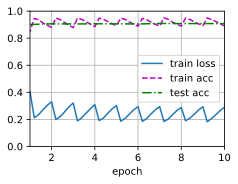

In [15]:
def init_weights(m):
    if type(m) in (nn.Linear, nn.Conv1d):
        nn.init.xavier_uniform_(m.weight)
net.apply(init_weights)

trainer = torch.optim.Adam([{"params": net.esm1b.parameters(), "lr": 1e-7}],
                            lr = 1e-7, weight_decay=1e-3)
net.train()
devices = utils.try_all_gpus()
loss = nn.CrossEntropyLoss(reduction="none").cuda()

#################################################加载checkpoint模块部分###################################################
RESUME = False
num_epochs = 10
start_epoch = 0

if RESUME:
    path_checkpoint = "./ESM_finetuning/checkpoint_cnn1d/bestmodel.pkl"  # 断点路径
    checkpoint = torch.load(path_checkpoint)  # 加载断点
    net.load_state_dict(checkpoint['net'])  # 加载模型可学习参数
    net.cuda()
    trainer.load_state_dict(checkpoint['optimizer'])  # 加载优化器参数
    start_epoch = checkpoint['epoch']  # 设置开始的epoch 
    # lr_schedule.load_state_dict(checkpoint['lr_schedule'])

main(net, train_dataloader, val_dataloader, loss, trainer, num_epochs, start_epoch, devices)
